In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

2024-11-18 21:12:21.118268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731935541.127059   30860 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731935541.129562   30860 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 21:12:21.138769: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define paths to your datasets
train_dir = 'BMEG3103_project/project1_dataset/train'
val_dir = 'BMEG3103_project/project1_dataset/val'
test_dir = 'BMEG3103_project/project1_dataset/test'


In [3]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.4, 1.6],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 698 images belonging to 2 classes.


In [5]:
# Load the pre-trained ResNet101 model
base_model = tf.keras.applications.ResNet101(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

for layer in base_model.layers[:50]:
    layer.trainable = False
for layer in base_model.layers[50:]:
    layer.trainable = True


I0000 00:00:1731935550.315423   30860 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13553 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])


In [7]:
# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Add early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define a learning rate scheduler
def cosine_annealing(epoch, lr, total_epochs):
    return 0.5 * lr * (1 + np.cos(np.pi * epoch / total_epochs))

# Define the total number of epochs
total_epochs = 100

In [8]:
# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lambda epoch, lr: cosine_annealing(epoch, lr, total_epochs))

# Train the model with learning rate scheduler
history = model.fit(
    train_generator,
    epochs=total_epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)


/home/user/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1731935578.179567   32948 service.cc:148] XLA service 0x7f431c006c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731935578.179593   32948 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2024-11-18 21:12:58.855662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731935581.538451   32948 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1731935594.292289   32948 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 ━━━━━━━━━━━━━━━━━━━━ 101s 947ms/step - accuracy: 0.5896 - loss: 5.5713 - val_accuracy: 0.7433 - val_loss: 4.8334 - learning_rate: 1.0000e-04
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 680ms/step - accuracy: 0.6340 - loss: 5.1045 - val_accuracy: 0.7433 - val_loss: 4.5474 - learning_rate: 9.9975e-05
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 676ms/step - accuracy: 0.6706 - loss: 4.7280 - val_accuracy: 0.7433 - val_loss: 4.3212 - learning_rate: 9.9877e-05
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 666ms/step - accuracy: 0.6825 - loss: 4.4254 - val_accuracy: 0.7433 - val_loss: 4.0952 - learning_rate: 9.9655e-05
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 668ms/step - accuracy: 0.7487 - loss: 4.0876 - val_accuracy: 0.7462 - val_loss: 3.8953 - learning_rate: 9.9262e-05
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 673ms/step - accuracy: 0.7531 - loss: 3.8868 - val_accuracy: 0.8779 - val_loss: 3.6043 - learning_rate: 9.8651e-05
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 692ms/step - accurac

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Get predictions and true labels
test_generator.reset()
preds = model.predict(test_generator)
preds = np.argmax(preds, axis=1)
true_labels = test_generator.classes

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 511ms/step - accuracy: 0.8088 - loss: 1.7324
Test Accuracy: 0.8682
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 479ms/step


In [10]:
# Calculate precision, recall, and confusion matrix
threshold = 0.5  # You can change this value to balance precision and recall
preds = (model.predict(test_generator)[:, 1] > threshold).astype(int)

test_precision = precision_score(true_labels, preds)
test_recall = recall_score(true_labels, preds)
f1 = f1_score(true_labels, preds)
conf_matrix = confusion_matrix(true_labels, preds)

print(f'F1 Score: {f1:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print('Confusion Matrix:')
print(conf_matrix)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step
F1 Score: 0.9013
Test Precision: 0.8400
Test Recall: 0.9722
Confusion Matrix:
[[186  80]
 [ 12 420]]


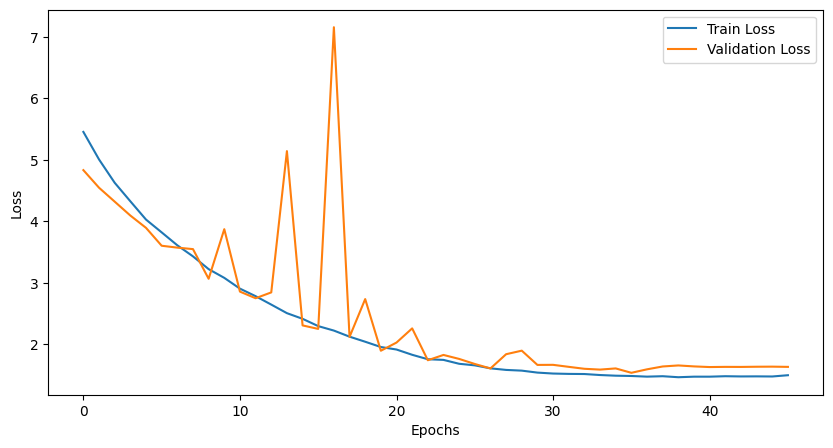

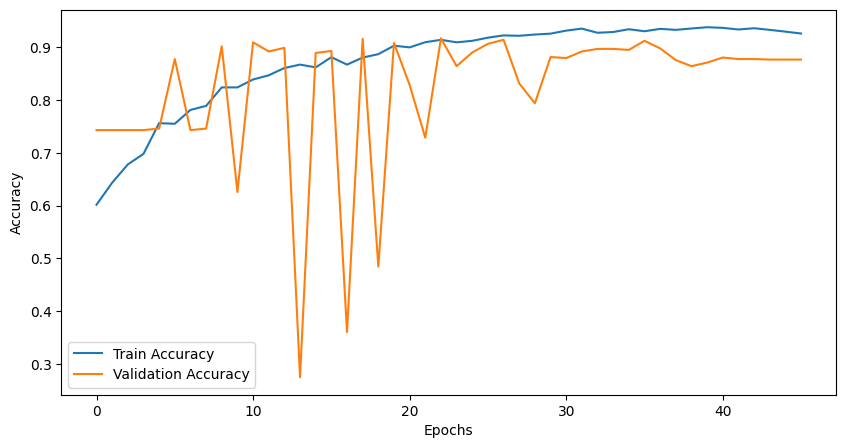

In [11]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy over epochs
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()